# MLP training on MNIST

1.   Testing on all 10000 images,because faster. Problem?
2.   Listeneintrag



In [1]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
import _pickle as cPickle
import pickle
import copy
from jax import jit, vmap, pmap, grad, value_and_grad
import random
from torchvision.datasets import MNIST
from torchvision.datasets import KMNIST
from torchvision.datasets import CIFAR100
from torchvision.datasets import CIFAR10
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from jax.example_libraries import stax, optimizers
import torchvision
import torch
from sklearn.neighbors import NearestNeighbors
import torch.utils.data as data_utils
from jax.flatten_util import ravel_pytree
import os
import time
import shutil
import _pickle as cPickle
from math import e
import time
from jax.example_libraries import stax
from jax.example_libraries.stax import Dense, Relu, LogSoftmax
from sklearn.model_selection import train_test_split
from jax import random 
import matplotlib.pyplot as plt
from torchvision import transforms
from itertools import cycle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
'''Global Variables'''


'''Set file directorys'''
googledrive_path="/content/drive/MyDrive/Colab Notebooks/Jax_Generalizer/"

Convu1_in=16
Convu2_in=24
Convu3_in=1

kernelsize_=(4,4)
batch_size = 50
n_offsp_epoch = 10
n_samples = 150

number_training_categories=5

## Logging

In [4]:
def logg_to_file (string_, array=None):
  if array is None:

    file1 = open(save_txt,"a")
    file1.write(string_)
    file1.write("\n")
    file1.close()
    
  if array is not None:

    file1 = open(save_txt,"a")
    file1.write(string_)
    file1.write(str(array))
    file1.write("\n")
    file1.close()

def log_variables():
    
    logg_to_file (("n_training_epochs = {}".format(n_training_epochs)))
    logg_to_file (("n_offsp_epoch = {}".format(n_offsp_epoch)))
    
    logg_to_file (("n_samples = {}".format(n_samples)))
    logg_to_file (("n_test = {}".format(n_test)))
    logg_to_file (("batch_size = {}".format(batch_size)))

    '''logg_to_file (("use_focus = {}".format(use_focus)))
    #logg_to_file (("focus_layer = {}".format(focus_layer)))
    logg_to_file (("focus_change_every = {}".format(focus_change_every)))

    
    logg_to_file (("use_sigma_decay = {}".format(use_sigma_decay)))
    logg_to_file (("n_decay_epochs = {}".format(n_decay_epochs)))
    logg_to_file (("sigma_start = {}".format(sigma_start)))
    logg_to_file (("sigma_goal = {}".format(sigma_goal)))

  
    logg_to_file (("use_KNN = {}".format(use_KNN)))
    logg_to_file (("KNN_n_neighbors = {}".format(KNN_n_neighbors)))
    logg_to_file (("KNN_top_n = {}".format(KNN_top_n)))
    logg_to_file (("n_KNN_subsprings = {}".format(n_KNN_subsprings)))





    logg_to_file (("use_sigma_decay = {}".format(use_sigma_decay)))
    logg_to_file (("sigma_start = {}".format(sigma_start)))
    logg_to_file (("sigma_goal = {}".format(sigma_goal)))
    logg_to_file (("n_decay_epochs = {}".format(n_decay_epochs)))
    logg_to_file (("use_pickle = {}".format(use_pickle)))
    logg_to_file (("pickle_path = {}".format(pickle_path)))
    logg_to_file (("use_father = {}".format(use_father)))'''


    logg_to_file (("NNin1 = {}".format(NNin1)))
    logg_to_file (("NNout1 = {}".format(NNout1)))
    logg_to_file (("Convu_in1 = {}".format(Convu1_in)))
    logg_to_file (("Convu2_in = {}".format(Convu2_in)))
    logg_to_file (("Convu3_in = {}".format(Convu3_in)))

    logg_to_file (("kernelsize_ = {}".format(kernelsize_)))
    
    logg_to_file (("n_metaepochs = {}".format(n_metaepochs)))
    #logg_to_file (("n_testing_epochs = {}".format(n_testing_epochs)))         
    logg_to_file (("n_offsp_epoch = {}".format(n_offsp_epoch)))
    logg_to_file (("n_offsprings = {}".format(n_offsprings)))
    logg_to_file (("std_modifier = {}".format(std_modifier)))
    #logg_to_file (("use_softmax = {}".format(use_softmax)))
    logg_to_file (("temperature = {}".format(temp)))

In [5]:
def pathandstuff():

    global save_txt
    global base_path
    global save_path

  
    if os.path.exists(googledrive_path):
        print("on google")
        base_path=googledrive_path
    else:
        raise ValueError('Please specify save path or connect to Google Drive')
        
    logs_path=base_path+"Logs/"
    '''Set logging and temp paths'''
    timestamp=time.strftime("%d.%m.%Y_%H.%M")
    foldername=timestamp
    save_path=os.path.join(logs_path,foldername,)
    save_path=save_path+"/"
    save_txt = os.path.join(save_path, 'Log_Jax_Generalizer_{}.txt'.format(foldername))

    
      
      
    print("Log path:",save_path)
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    




def logg_script(file_name, save_path):
  source=f"/content/drive/MyDrive/Colab Notebooks/{file_name}"
  destination=save_path+f"{file_name}.ipynb"
  shutil.copy2(source, destination)

'''logging to txt and print'''
def logg (string_, array=None):
  if array is None:

    file1 = open(save_txt,"a")
    file1.write(string_)
    file1.write("\n")
    file1.close()
    print(string_)
  if array is not None:

    file1 = open(save_txt,"a")
    file1.write(string_)
    file1.write(str(array))
    file1.write("\n")
    file1.close()
    print(string_, array)

## **Funktions**

Changes in Jax Jit function (sometimes?) need a cache restart for changes to be applied. Happened with def accuracy

In [6]:
data_image_size=32
data_image_depth=3

train_dataset = CIFAR100(root='train_mnist', train=True, download=True,transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
                                            ]))

test_dataset = CIFAR100(root='test_mnist', train=False, download=True,transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
                                           ]))

x = np.concatenate((train_dataset.data,test_dataset.data))
y= np.concatenate((train_dataset.targets,test_dataset.targets))

'''x_known = x[np.isin(y, list(range(0, 25))).flatten()]
y_known = y[np.isin(y, list(range(0, 25))).flatten()]
x_known = jnp.array(x_known,dtype="float32").reshape(len(x_known), -1)
y_known = jnp.array(y_known)

x_unknown = x[np.isin(y, list(range(25, 50))).flatten()]
y_unknown = y[np.isin(y, list(range(25, 50))).flatten()]
x_unknown = jnp.array(x_unknown,dtype="float32").reshape(len(x_unknown), -1)
y_unknown = jnp.array(y_unknown)'''

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting train_mnist/cifar-100-python.tar.gz to train_mnist


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting test_mnist/cifar-100-python.tar.gz to test_mnist


'x_known = x[np.isin(y, list(range(0, 25))).flatten()]\ny_known = y[np.isin(y, list(range(0, 25))).flatten()]\nx_known = jnp.array(x_known,dtype="float32").reshape(len(x_known), -1)\ny_known = jnp.array(y_known)\n\nx_unknown = x[np.isin(y, list(range(25, 50))).flatten()]\ny_unknown = y[np.isin(y, list(range(25, 50))).flatten()]\nx_unknown = jnp.array(x_unknown,dtype="float32").reshape(len(x_unknown), -1)\ny_unknown = jnp.array(y_unknown)'

19


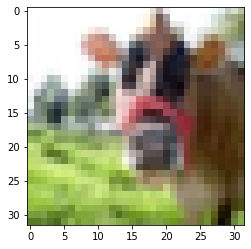

In [7]:
'''Show image and label'''
idx=0
plt.imshow(transforms.ToPILImage()(x[idx]))
print(train_dataset.targets[idx])

In [8]:
def init_MLP(layer_widths, parent_key, scale=0.01):

    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )
    return params



In [9]:
@jit
def MLP_predict(params, x):

    hidden_layers = params[:-1]
    activation = x

    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    return logits - logsumexp(logits)

jit_MLP_predict=jit(MLP_predict)

@jit
def batched_MLP_predict(params,x):
  return vmap(jit_MLP_predict, (None, 0))(params,x)
  
jit_batched_MLP_predict=jit(batched_MLP_predict)


In [10]:


conv_init, conv_apply = stax.serial(
    stax.Conv(Convu1_in,kernelsize_, padding="SAME"),
    stax.BatchNorm(),
    stax.Relu,
    stax.MaxPool((2,2)),
    stax.Conv(Convu2_in, kernelsize_, padding="SAME"),
    stax.BatchNorm(),
    stax.Relu,
    stax.MaxPool((2,2)),
    stax.Conv(Convu3_in, kernelsize_, padding="SAME"),
    stax.Relu,
    stax.MaxPool((4,4)),
    stax.MaxPool((4,4)),
    stax.MaxPool((5,5))
)


In [11]:
'''After changing Convu structure test if convu out and NN in matches, 
Error:Cannot divide evenly the sizes of shapes (5, 21, 21, 1) and (-1, 440)
NNin1 needs to be 21*21= 441'''

NNin1=400
NNout1=number_training_categories
rng=jax.random.PRNGKey(1)

father_weights = conv_init(rng, (batch_size,data_image_size,data_image_size,data_image_depth))
father_weights = father_weights[1]

x_test = jnp.array(x,dtype="float32").reshape(len(x), -1)

x_train=x_test[random.randint(rng, (n_offsp_epoch*n_samples,), 0, 15000, dtype='uint8')]
testaffe=x_train[0:5]


imgs = conv_apply(father_weights, testaffe.reshape(-1,data_image_size,data_image_size,data_image_depth))

MLP_params = init_MLP([NNin1, NNout1], rng)

pred_classes = jnp.argmax(jit_batched_MLP_predict(MLP_params, imgs.reshape(-1,NNin1)), axis=1)

In [12]:
@jit
def loss_fn(params, imgs, gt_lbls):
  
    predictions = jit_batched_MLP_predict(params, imgs)
    #print("predictions",predictions.shape)
    return -jnp.mean(predictions * gt_lbls)
    
jit_loss_fn=jit(loss_fn)

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

    return loss, jax.tree_map(lambda p, g: p - lr*g, params, grads)

jit_update=jit(update)

@jit
def accuracy(conv_weights,MLP_params, dataset_imgs, dataset_lbls):

    imgs = conv_apply(conv_weights, dataset_imgs.reshape(-1,data_image_size,data_image_size,data_image_depth))
    pred_classes = jnp.argmax(jit_batched_MLP_predict(MLP_params, imgs.reshape(-1,NNin1)), axis=1)
    #pred_classes= jnp.array(np.array(pred_classes)+np.min(dataset_lbls))
    '''If MLP output is only 5 classes, but it is trained on labels 10-15, pred_classes needs to be adjusted by np.min(dataset_lbls)
    otherwise acc = 0'''
    return jnp.mean(dataset_lbls == pred_classes+jnp.min(dataset_lbls))
    
jit_accuracy=jit(accuracy)


In [13]:
'''For loop is neccesary to do batch training. Every update iteration needs to run with updated MPL params'''
@jit
def train(conv_weights, imgs, lbls,MLP_params ):
  for n in range(n_training_epochs):  
    for i in range(jnp.shape(imgs)[0]):

      gt_labels = jax.nn.one_hot(lbls[i], number_training_categories)
      img_conv = conv_apply(conv_weights, imgs[i].reshape(-1,data_image_size,data_image_size,data_image_depth))
      loss, MLP_params = jit_update(MLP_params, img_conv.reshape(-1,NNin1), gt_labels)

  return MLP_params
  
jit_train=jit(train)  

In [14]:
'''
Running for every offspring n_offsp_epoch loops to get stable acc results. 
Every loop is trained with n_samples/batch_size * batch size training epochs.
Everything put in jit and vmap to speed up

Input  
(10, 6, 25, 28, 28, 1) x_train
(10, 6, 25) y_train
(10, 1000, 28, 28, 1) test_img_off
(10, 1000) test_lbl_off
          
(n_offsp_epoch, n_samples/batch_size, batch size, 28, 28, 1)
(n_offsp_epoch, n_samples/batch_size, batch size)
(n_offsp_epoch, n_test, 28, 28, 1)
(n_offsp_epoch, n_test)'''

@jit
def bootstrapp_offspring_MLP(key,conv_weights, batch_affe, labelaffe,test_images,test_lbls):
  
  
  MLP_params = init_MLP([NNin1, NNout1], key)
  MLP_params_trained=jit_train(conv_weights, batch_affe, labelaffe,MLP_params )
 
  
  result=jit_accuracy(conv_weights,MLP_params_trained,test_images,test_lbls)
  return (result)

jit_bootstrapp_offspring_MLP=jit(bootstrapp_offspring_MLP)  

@jit
def vmap_bootstrapp_offspring_MLP(key, conv_weights, batch_affe, labelaffe,test_images,test_lbls):
  return vmap(jit_bootstrapp_offspring_MLP, ( None,None, 0,0,0,0))(key, conv_weights, batch_affe, labelaffe,test_images,test_lbls)
  
jit_vmap_bootstrapp_offspring_MLP=jit(vmap_bootstrapp_offspring_MLP)


In [15]:
'''creating offsprings, filling treeleaf of 0 and 1 with gaussian noise, doesnt seem to be a problem, ex in offspring_list[0][5]'''

def jax_create_offsprings(key,n_offspr,  fath_weights,std_modifier):
  statedic_list=[]
  for i in range(0,n_offspr):
    rng=jax.random.PRNGKey(key+i)
    random_value_tree=tree_random_normal_like(rng,fath_weights,std_modifier)
    son=jax.tree_map(lambda x,y: x+y, fath_weights,random_value_tree)
    statedic_list.append(son)

  return statedic_list

def random_split_like_tree(rng_key, target=None, treedef=None):
    if treedef is None:
        treedef = jax.tree_structure(target)
    keys = jax.random.split(rng_key, treedef.num_leaves)
    return jax.tree_unflatten(treedef, keys)


def tree_random_normal_like(rng_key, target,std_modifier):
    keys_tree = random_split_like_tree(rng_key, target)
    return jax.tree_map(
        lambda l, k: jax.random.normal(k, l.shape, l.dtype)*std_modifier,
        target,
        keys_tree,
    )

In [16]:
'''softmax for offspring list
    checked 11.04 working correctly'''
def softmax_offlist(off_list,acc_list,temp):
  softmax_list=softmax_result(acc_list,temp)
  for i in range(len(off_list)):
    if i==0:
      top_dog=jax.tree_map(lambda x: x*softmax_list[i], off_list[i])
    else:
      general_dog = jax.tree_map(lambda x: x*softmax_list[i], off_list[i])
      top_dog=jax.tree_map(lambda x,y: x+y, top_dog,general_dog)
  return top_dog


'''Creates softmax/temp list out of accuracy list [0.2,0.3,....,0.8]'''
def softmax_result(results,temp: float):
    x = [z/temp for z in results]
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [17]:
'''Cycle through training labels'''
cat_cycle_train=[0,5,10,15,20,25,30,35,40,45]

cat_cycle_train= cycle(cat_cycle_train)
def next_cat_train():
  return next(cat_cycle_train)

'''Cycle through testing labels'''
cat_cycle_test=[50,55,60,65,70,75,80,85,90,95]

cat_cycle_test= cycle(cat_cycle_test)
def next_cat_test():
  return next(cat_cycle_test)

In [18]:
'''result_dic is defined as global'''
def save_results_dic(cat_means,range_start):
    if f"({range_start},{range_start+5})" in result_dic:
      helper=result_dic[f"({range_start},{range_start+5})"]
    else:
      helper=[]
    helper.append(cat_means)
    result_dic[f"({range_start},{range_start+5})"]=helper

In [24]:
'''Initialize Variables'''

n_metaepochs=100000
n_offsprings=250

n_samples = 150 #n of training independent training samples for 2nd network - MLP, samples are stratified
n_training_epochs=20 #= how many times, is the same MLP trained with the same data. Reduces dependance on the initialization of MLP weights
batch_size = 25

n_test=150
n_offsp_epoch=10 #Bootstrapping, delivers more stable results for every offspring. Number of 2nd Networks per Offspring for testing

'''keys'''
starting_key=152 #define starting point
MLP_key=1369 #seed 
numpy_seed=1854 #in create offsprings



use_Softmax=True #weight update method
use_father=True
std_modifier=0.05
temp=0.05
#training_temp=0.05 #weight for softmax
#testing_temp=0.01

file_name="Jax_Cifar100.ipynb"

'''load best weight from log directory'''
use_pickle=False #load single weight as father weight
use_best_weights=False
pickle_path="/content/drive/MyDrive/Colab Notebooks/Jax_MNist/Logs/19.04.2022_2parallel/best_weight_0.8865.pkl"
use_father=True

'''Load all best weights from log directory'''
use_all_pickle=False
all_pickle_path="/content/drive/MyDrive/Colab Notebooks/Jax_Generalizer/Logs/22.06.2022_20.39/"
all_pickle_children=10 #number of offsprings per pickle 



# Main Code

In [25]:


'''Initialize variables'''
global result_dic
result_dic={}

rng_MLP=jax.random.PRNGKey(MLP_key)
results_meta=[]
best_performer=[0.0,0.0]
father_key=jax.random.PRNGKey(starting_key)
best_weights=conv_init(father_key, (batch_size,data_image_size,data_image_size,data_image_depth))[1]
common_start_acc=0
training_cat_means=[]
testing_cat_means=[]

'''Initialize Logging'''
pathandstuff()
logg_script(file_name, save_path)
log_variables()


for meta in range (n_metaepochs):
    start_meta = time.time()
    

    '''Starting point'''
    if meta ==0:

        '''Loading all best weights from log folder and creates offsprings from that'''
        if use_all_pickle:
          offspring_list=[]
          for i in os.listdir(all_pickle_path):
            if ".pkl" in i:
              with open(all_pickle_path+i, "rb") as input_file:
                father_weights = cPickle.load(input_file)
                offspring_list.append(father_weights)
                offspring_list.extend(jax_create_offsprings((starting_key),all_pickle_children, father_weights,std_modifier))
            

        elif use_pickle:
            with open(pickle_path, "rb") as input_file:
              father_weights = cPickle.load(input_file)
              print("pickle weights imported") 
            offspring_list=jax_create_offsprings((meta+numpy_seed),n_offsprings, father_weights,std_modifier)
            if use_father:
              offspring_list[0]=father_weights

        else:
          father_weights = conv_init(father_key, (batch_size,data_image_size,data_image_size,data_image_depth))
          father_weights = father_weights[1] ## Weights are actually stored in second element of two value tuple
          offspring_list=jax_create_offsprings((meta+numpy_seed),n_offsprings, father_weights,std_modifier)
          if use_father:
            offspring_list[0]=father_weights


    '''Weight updates'''      
    if meta >=1:

        '''Softmax Update'''
        '''Disabled weight update for testing epoch'''
        if use_Softmax and not (meta % 10 == 0 or meta==0):
          grand_father=offspring_list[0]
          father_weights=softmax_offlist(offspring_list,[x[0] for x in result_list_metaepoch],temp)
          offspring_list=jax_create_offsprings((meta+numpy_seed),n_offsprings, father_weights,std_modifier)
          if use_father:
            offspring_list[0]=grand_father
            offspring_list[1]=best_weights
            offspring_list[2]=father_weights
        
          
    result_list_metaepoch=[]

    '''Load "known data" at meta=0 and after every test period'''
    if (((meta-1) % 10 == 0 or meta==0) and meta !=1):
      
      if testing_cat_means:
        save_results_dic(testing_cat_means,range_start)
        testing_cat_means=[]
      
      
      range_start=next_cat_train()
      logg("load known data for metaepoch: ", meta)
      logg(f"Label range: ({range_start},{range_start+5})")

      '''use only consecutive categories, otherwise problems in def accuracy'''
      x_data0 = x[np.isin(y, list(range(range_start, range_start+5))).flatten()]
      y_data0 = y[np.isin(y, list(range(range_start, range_start+5))).flatten()]
      
      y_data0 = y_data0 - range_start #adjust labels to remove acc bug
      x_data0 = jnp.array(x_data0,dtype="float32").reshape(len(x_data0), -1)
      y_data0 = jnp.array(y_data0)
      x_input = x_data0
      y_input = y_data0
      


      '''Load "unknown data" every 10th meta run'''
    elif (meta % 10 == 0 and meta !=0):
      if training_cat_means:
        save_results_dic(training_cat_means,range_start)
        training_cat_means=[]
      range_start=next_cat_test()
      
      logg("load unknown data for metaepoch: ", meta)  
      logg(f"Label range: ({range_start},{range_start+5})")

      '''use only consecutive categories, otherwise problems in def accuracy'''
      x_data10 = x[np.isin(y, list(range(range_start, range_start+5))).flatten()]
      y_data10 = y[np.isin(y, list(range(range_start, range_start+5))).flatten()]
      x_data10 = jnp.array(x_data10,dtype="float32").reshape(len(x_data10), -1)
      y_data10 = y_data10 - range_start #adjust labels to remove acc bug
      y_data10 = jnp.array(y_data10)
      x_input = x_data10
      y_input = y_data10

    
    

    '''Split is outside of offspring loop = every offspring trained with same data'''
    x_train, x_test, y_train, y_test = train_test_split(x_input, y_input, train_size=n_offsp_epoch*n_samples,
                                                          test_size=n_offsp_epoch*n_test,stratify=y_input,
                                                          random_state=(starting_key+meta))
    
    

    x_train=x_train.reshape(n_offsp_epoch,int((n_samples/batch_size)),batch_size,data_image_size,data_image_size,data_image_depth)
    y_train=y_train.reshape(n_offsp_epoch,int((n_samples/batch_size)),batch_size)
    x_test=x_test.reshape(n_offsp_epoch,n_test,data_image_size,data_image_size,data_image_depth)
    y_test=y_test.reshape(n_offsp_epoch,n_test)

    #print("Shape x_train",np.shape(x_train))
    #print("Shape y_train",np.shape(y_train))
    #print("Shape x_test",np.shape(x_test))
    #print("Shape y_test",np.shape(y_test))
    
    #print("\tLänge Offspring List:",len(offspring_list))
    for i in range(len(offspring_list)):

      conv_weights=offspring_list[i]
      result_off=jit_vmap_bootstrapp_offspring_MLP(rng_MLP,conv_weights,x_train,y_train,x_test,y_test)
      result_off2=[float(jnp.mean(result_off)),float(jnp.std(result_off))]
      result_list_metaepoch.append(result_off2)


      '''Check for best performer'''
      if result_off2[0]>best_performer[0]:
        best_performer=result_off2
        best_weights=conv_weights
        common_start_acc=result_off2[0]
        with open(save_path+f"best_weight_{result_off2[0]:.4f}.pkl", 'wb') as f:
          pickle.dump(best_weights, f, pickle.HIGHEST_PROTOCOL)
          f.close()
        #logg(f"New best performer mean: {best_performer[0]:.4f}, std: {best_performer[1]:.2f}")

    '''Save training and testing results'''
    metaepoch_mean=np.mean(np.array([x[0] for x in result_list_metaepoch]))      
    if (meta % 10 == 0 and meta !=0):
      testing_cat_means.append(metaepoch_mean)
    else:
      training_cat_means.append(metaepoch_mean)
    
    '''Save result_dic'''
    if meta % 100 == 0:
      with open(save_path+"results_dic.pkl", 'wb') as f:
          pickle.dump(result_dic, f, pickle.HIGHEST_PROTOCOL)
          f.close()


    logg("\tMetaepoch mean: {:.4f}, std: {:.2f}".format(np.mean(np.array([x[0] for x in result_list_metaepoch])),np.std(np.array([x[0] for x in result_list_metaepoch]))))
    logg("\tMetaepoch max performer: {:.4f}, min performer: {:.4f}".format(np.max(np.array([x[0] for x in result_list_metaepoch])),np.min(np.array([x[0] for x in result_list_metaepoch]))))
    logg("\tTime per metaepoch:{:.1f}s\n".format(time.time() - start_meta))
    results_meta.append(np.mean(np.array(result_list_metaepoch), axis=0))

on google
Log path: /content/drive/MyDrive/Colab Notebooks/Jax_Generalizer/Logs/23.06.2022_13.59/
load known data for metaepoch:  0
Label range: (10,15)
	Metaepoch mean: 0.2649, std: 0.03
	Metaepoch max performer: 0.3427, min performer: 0.2080
	Time per metaepoch:12.3s

	Metaepoch mean: 0.2810, std: 0.03
	Metaepoch max performer: 0.3687, min performer: 0.2180
	Time per metaepoch:12.7s



KeyboardInterrupt: ignored

In [ ]:
len(offspring_list)

In [ ]:
result_dic

# **Testing**

In [ ]:
x_data = x[np.isin(y, list(range(10, 15))).flatten()]

In [ ]:
x_data10

# Archiv